In [62]:
## import modules


import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
% matplotlib inline

import glob
import os
import math

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing



In [63]:
# Processing Compressed Mortality datasets into a pandas dataframe

# get a list of the data files the direction
onlyfiles = [f for f in listdir('data/Compressed Mortality/') if isfile(join('data/Compressed Mortality/', f))]
print(onlyfiles)

# for each txt file...
for i in np.arange(len(onlyfiles)):

    data_temp = pd.read_table('data/Compressed Mortality/' + onlyfiles[i], header='infer', index_col=None,  names=('Notes', 'County', 'County Code', 'Deaths', 'Population', 'Crude Rate'))
    data_dropped = data_temp.iloc[1:] #Remove the first row because it's the files's header
    data_dropped['County Code'] = pd.to_numeric(data_dropped['County Code']) # Make the zipcode a float instead of a string

    data_dropped.insert(0, 'year', int(onlyfiles[i][-8:-4])) # Add the year as a column
    if i == 0:
        data = data_dropped
    else:
        data = pd.concat([data, data_dropped]) # add each year's text file to the overall dataframe


data_sorted = data.sort_values(by=['County Code', 'year']) # put in order
data_mortality = data_sorted

# reset the index to easily combine with the other dataframes
data_mortality.set_index(['County Code', 'year'], inplace=True, drop =False)


temp = np.zeros((data_mortality.shape[0],1))
unreliable = np.zeros((data_mortality.shape[0],1))
for i in range(data_mortality.shape[0]):
    
    # add a feature for if the death rate is reliable or not
    try:
        temp[i] = float(data_mortality['Crude Rate'].iloc[i].split()[0])
        unreliable[i] = 1
    except:
        temp[i] = float(data_mortality['Crude Rate'].iloc[i])
        unreliable[i] = 0
        
data_mortality['Crude Rate'] =temp


['Compressed Mortality, 1999.txt', 'Compressed Mortality, 2000.txt', 'Compressed Mortality, 2001.txt', 'Compressed Mortality, 2002.txt', 'Compressed Mortality, 2003.txt', 'Compressed Mortality, 2004.txt', 'Compressed Mortality, 2005.txt', 'Compressed Mortality, 2006.txt', 'Compressed Mortality, 2007.txt', 'Compressed Mortality, 2008.txt', 'Compressed Mortality, 2009.txt', 'Compressed Mortality, 2010.txt', 'Compressed Mortality, 2011.txt', 'Compressed Mortality, 2012.txt', 'Compressed Mortality, 2013.txt', 'Compressed Mortality, 2014.txt', 'Compressed Mortality, 2015.txt', 'Compressed Mortality, 2016.txt']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [64]:
# compile the perscrption drugs datsets into a pandas dataframe

# Get all the relevant csv files
onlyfiles = [f for f in listdir('data/Prescriptions/') if isfile(join('data/Prescriptions/', f))]

print(onlyfiles)

# For all the files...
for i in np.arange(len(onlyfiles)):
    # load the CSV
    data_temp = pd.read_csv('data/Prescriptions/' + onlyfiles[i], index_col=None,  names=('State', 'County Code', 'Opioid Perscription Rate'))
    
    # Insert the year as a column in the dataframe
    data_temp.insert(0, 'year', int(onlyfiles[i][-8:-4]))
    if i == 0:
        data = data_temp
    else:
        data = pd.concat([data, data_temp]) # Add to the overall dataframe


data_sorted = data.sort_values(by=['County Code', 'year'])


data_perscriptions = data_sorted

data_perscriptions.set_index(['County Code', 'year'], inplace=True, drop =False)

['rxrate_2006.csv', 'rxrate_2007.csv', 'rxrate_2008.csv', 'rxrate_2009.csv', 'rxrate_2010.csv', 'rxrate_2011.csv', 'rxrate_2012.csv', 'rxrate_2013.csv', 'rxrate_2014.csv', 'rxrate_2015.csv', 'rxrate_2016.csv']


In [65]:
# compile county health statistics into a pandas dataframe

def create_fips_code(df):
    fips_code = []
    for i in range(df['statecode'].shape[0]):
        # combine the statecode and countycode to create the fips_code
        string = '{:d}{:03d}'.format(df['statecode'].iloc[i], df['countycode'].iloc[i])
        fips_code.append(int(string)) 
    return fips_code

# load all data into a single dataframe
data_dir = 'data/county health rankings'
file_wildcard = os.path.join(data_dir, '*.csv')
for i, filepath in enumerate(reversed(glob.glob(file_wildcard))):
    year = filepath.split('/')[-1].split('\\')[-1].split(' ')[0]
    print(i, filepath, year)
    
    # load the data
    data = pd.read_csv(filepath)
    # convert all columns to lower case
    data.columns = map(str.lower, data.columns)
    # calculate the fips_code and insert as 1st column
    data.insert(loc=0, column='County Code', value=create_fips_code(data))
    # insert the year as the 2nd column
    data.insert(loc=1, column='year', value=int(year))
    #
    if i == 0:
        df = data
        orig_columns = data.columns
    else:
        df = pd.concat([df, data])


data_health_statistics = df

data_health_statistics = data_health_statistics.sort_values(by=['County Code', 'year'])

data_health_statistics.set_index(['County Code', 'year'], inplace=True, drop =False)

0 data/county health rankings\2017 CHR analytic data.csv 2017
(3186, 358)
1 data/county health rankings\2016 CHR analytic data.csv 2016
(3191, 356)
2 data/county health rankings\2015 CHR analytic data.csv 2015
(3191, 331)
3 data/county health rankings\2014 CHR analytic data.csv 2014
(3191, 326)
(12759, 373)


In [66]:
# combine the census data into a pandas dataframe

def create_fips_code(df):
    fips_code = []
    for i in range(df['state fips code'].shape[0]):
        # combine the statecode and countycode to create the fips_code
        string = '{:d}{:03d}'.format(df['state fips code'].iloc[i], df['county fips code'].iloc[i])
        fips_code.append(int(string)) 
    return fips_code

# load the data
data_2016 = pd.read_csv('data/census/2016_census.csv', encoding='utf-8')
data_2015 = pd.read_csv('data/census/2015_census.csv', encoding='utf-8')
print(data_2016.shape)
print(data_2015.shape)
# convert all columns to lower case
data_2016.columns = map(str.lower, data_2016.columns)
data_2015.columns = map(str.lower, data_2015.columns)
# calculate the fips_code and insert as 1st column
data_2016.insert(loc=0, column='County Code', value=create_fips_code(data_2016))
data_2015.insert(loc=0, column='County Code', value=create_fips_code(data_2015))
# insert the year as the 2nd column
data_2016.insert(loc=1, column='year', value=int(2016))
data_2015.insert(loc=1, column='year', value=int(2015))

def replace_substring_in_list(str_list, target_substring, replace_substring):
    new_list = []
    for s in str_list:
        if target_substring in s:
            s = s.replace(target_substring, replace_substring)
        new_list.append(s)
    return new_list

# resolve like-column name mismatches
data_2016.columns = replace_substring_in_list(data_2016.columns, '2016 ', '')
data_2016.columns = replace_substring_in_list(data_2016.columns, 'all people!!', '')
data_2016.columns = replace_substring_in_list(data_2016.columns, 'poverty level!!18 years and over!!', 'poverty level!!')

data_2015.columns = replace_substring_in_list(data_2015.columns, '2015 ', '')
data_2015.columns = replace_substring_in_list(data_2015.columns, 'poverty level!!65 years and over!!', 'poverty level!!')

# concatenate data into a single dataframe
data_census = pd.concat([data_2016, data_2015])
data_census.set_index(['County Code', 'year'], inplace=True, drop=False)

(3220, 1342)
(3220, 1342)


In [67]:
# combine the four dataframes
data = data_mortality.join(data_perscriptions, how='outer', 
                           lsuffix='_data_mortality', rsuffix='_data_perscriptions')
data = data.join(data_health_statistics, how='outer', 
                 lsuffix='', rsuffix='_data_health_statistics')
data = data.join(data_census, how='outer',
                 lsuffix='', rsuffix='_data_census')

data = data.drop('year', axis=1)

# add year as a variable
# data is all three dataframes with nothing removed
data['year_keep'] = data.index.get_level_values('year')


In [69]:
# remove rows with no response variable

print(data.shape)

null_dataframe = data.isnull()
data = data.drop(data[null_dataframe["Crude Rate"]].index, inplace=False)

print(data.shape)




(41162, 1730)
(11798, 1730)


In [70]:
# remove useless features or features that are basically the same as the response variable

#print(list(data_census.columns.values))

to_remove = ['canonical name for geography','countycode', 'statecode', 'county that was not ranked', 'drug overdose deaths: modeled upper confidence interval', 'county', 'state', 'drug overdose deaths value', 'Notes','County','County Code_data_mortality','Deaths','Population','State','County Code_data_perscriptions','5-digit fips code','County Code','drug overdose deaths lower confidence interval','drug overdose deaths numerator','drug overdose deaths upper confidence interval','drug overdose deaths: modeled denominator','drug overdose deaths: modeled lower confidence interval','drug overdose deaths: modeled value']

for i in np.arange(len(to_remove)):
    data.drop(to_remove[i], axis=1, inplace = True)


['County Code', 'canonical name for geography', 'county', 'county fips code', 'estimate!!ancestry!!total population', 'estimate!!ancestry!!total population!!american', 'estimate!!ancestry!!total population!!american.1', 'estimate!!ancestry!!total population!!arab', 'estimate!!ancestry!!total population!!arab.1', 'estimate!!ancestry!!total population!!czech', 'estimate!!ancestry!!total population!!czech.1', 'estimate!!ancestry!!total population!!danish', 'estimate!!ancestry!!total population!!danish.1', 'estimate!!ancestry!!total population!!dutch', 'estimate!!ancestry!!total population!!dutch.1', 'estimate!!ancestry!!total population!!english', 'estimate!!ancestry!!total population!!english.1', 'estimate!!ancestry!!total population!!french (except basque)', 'estimate!!ancestry!!total population!!french (except basque).1', 'estimate!!ancestry!!total population!!french canadian', 'estimate!!ancestry!!total population!!french canadian.1', 'estimate!!ancestry!!total population!!german', 'e

In [71]:
feature_names = data.columns.values

# only use the "values" from the health statistics data
for i in np.arange(len(feature_names)):
    if feature_names[i].find('denominator') != -1:
        data.drop(feature_names[i], axis=1, inplace = True)
    if feature_names[i].find('numerator') != -1:
        data.drop(feature_names[i], axis=1, inplace = True)
    if feature_names[i].find('confidence') != -1:
        data.drop(feature_names[i], axis=1, inplace = True)

print(data.shape)

feature_names = data.columns.values

# only use percentages from the census data

for i in np.arange(len(feature_names)):
    if feature_names[i].find('estimate') != -1:
        data.drop(feature_names[i], axis=1, inplace = True)
        
print(data.shape)


(11798, 1707)
(11798, 1425)
(11798, 1425)
(11798, 755)


In [78]:
# check what the features are

print(data.columns.values)

['year_data_mortality' 'Crude Rate' 'year_data_perscriptions'
 'Opioid Perscription Rate' 'access to exercise opportunities value'
 'adult obesity value' 'adult smoking value'
 'air pollution - particulate matter value'
 'alcohol-impaired driving deaths value' 'child mortality value'
 'children eligible for free lunch value' 'children in poverty value'
 'children in single-parent households value'
 'could not see doctor due to cost value' 'dentists ratio' 'dentists value'
 'diabetes value' 'diabetic screening value' 'disconnected youth value'
 'drinking water violations value' 'driving alone to work value'
 'excessive drinking value' 'firearm fatalities value'
 'food environment index value' 'food insecurity value'
 'frequent mental distress value' 'frequent physical distress value'
 'health care costs value' 'high school graduation value'
 'hiv prevalence rate value' 'homicide rate value'
 'inadequate social support value' 'income inequality value'
 'infant mortality value' 'injury de

In [79]:

# Make the weird entires in the this features more normal
drinking_water = data['drinking water violations value'].values
drinking_water[drinking_water == 'Yes'] = 1.0
drinking_water[drinking_water == 'No'] = 0.0
drinking_water[drinking_water == '.'] = 0.0

data['drinking water violations value'] = pd.to_numeric(data['drinking water violations value'])



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [81]:
# turn string ratios into floats

object_variables = ['dentists ratio', 'mental health providers ratio', 'other primary care providers ratio', 'primary care physicians ratio']

for z in np.arange(len(object_variables)):

    mh = data[object_variables[z]].values

    for i in np.arange(data.shape[0]):
        try:
            a = mh[i].find(':')
    #        print(float(mh[i][:a]))
    #        print(1.0/float(mh[i][:a]))

            mh[i] = 1.0/float(mh[i][:a])
    #        print(mh[i])
        except:
            mh[i] = mh[i]

    data[object_variables[z]] = pd.to_numeric(mh)

In [80]:
# Check that there are no more columns that are the object datatype
data.select_dtypes(include=['O'])

Empty DataFrame
Columns: []
Index: [(1003, 2015), (1003, 2016), (1009, 2015), (1009, 2016), (1015, 2015), (1015, 2016), (1043, 2015), (1043, 2016), (1049, 2015), (1049, 2016), (1055, 2015), (1055, 2016), (1069, 2015), (1073, 2015), (1073, 2016), (1077, 2016), (1081, 2015), (1089, 2015), (1089, 2016), (1095, 2015), (1095, 2016), (1097, 2015), (1097, 2016), (1101, 2015), (1101, 2016), (1103, 2015), (1103, 2016), (1115, 2015), (1115, 2016), (1117, 2015), (1117, 2016), (1123, 2016), (1125, 2015), (1125, 2016), (1127, 2015), (1127, 2016), (2020, 2015), (2020, 2016), (2090, 2015), (2090, 2016), (2122, 2015), (2122, 2016), (2170, 2015), (2170, 2016), (4003, 2015), (4003, 2016), (4005, 2015), (4005, 2016), (4007, 2015), (4007, 2016), (4013, 2015), (4013, 2016), (4015, 2015), (4015, 2016), (4017, 2015), (4017, 2016), (4019, 2015), (4019, 2016), (4021, 2015), (4021, 2016), (4025, 2015), (4025, 2016), (4027, 2015), (4027, 2016), (5005, 2015), (5007, 2015), (5007, 2016), (5021, 2015), (5031, 2015), (5033, 2015), (5033, 2016), (5045, 2015), (5045, 2016), (5051, 2015), (5051, 2016), (5055, 2015), (5069, 2015), (5085, 2016), (5093, 2016), (5115, 2016), (5119, 2015), (5119, 2016), (5125, 2015), (5125, 2016), (5131, 2015), (5131, 2016), (5143, 2015), (5143, 2016), (5145, 2015), (5145, 2016), (6001, 2015), (6001, 2016), (6007, 2015), (6007, 2016), (6009, 2015), (6013, 2015), (6013, 2016), (6017, 2015), (6017, 2016), (6019, 2015), ...]

[1846 rows x 0 columns]

In [83]:
# remove rows from years before 2014 because we are only able to process census data from 2015/2016
print(data.shape)

years = data.index.get_level_values('year')

small_years = years < 2015.0
data = data.drop(data[small_years].index, inplace=False)





(1846, 755)
(1846, 755)


In [84]:
# drop columns that are entirely nan
data.dropna(axis=1, how='all', thresh=None, subset=None, inplace=True)

# fill nans
data = data.apply(lambda x: x.fillna(x.median()),axis=0)

# remove the response variable from the data
response = data['Crude Rate']
features = data.drop('Crude Rate', axis=1, inplace = False)
features = features.drop('year_keep', axis=1, inplace = False)




In [85]:
# separate the data into a 50% train and 50% test set

trainX, devX, trainY, devY = model_selection.train_test_split(preprocessing.scale(features), response, test_size=0.5, random_state=94305)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[[ 136.91321003]
 [ 136.12859062]
 [ 129.43873828]
 [ 108.86892277]
 [ 101.10291999]
 [  96.11305975]
 [  95.41393   ]
 [  97.83444776]
 [ 104.94505719]
 [ 114.71643227]
 [ 123.6276583 ]]


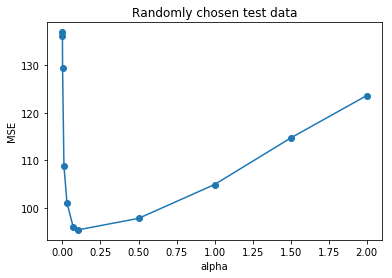

In [97]:
# fit lasso regression


# test a range of alpha parameters
alpha = [0.00001, 0.0001,0.001,0.01,0.03, 0.07,0.1,0.5,1, 1.5, 2]
mse = np.zeros((len(alpha),1))
for i in np.arange(len(alpha)):
    lreg = linear_model.Lasso(alpha = alpha[i], max_iter=10000)
    lreg.fit(trainX, trainY)

    pred = lreg.predict(devX)

    mse[i] = np.mean((pred - devY)**2)
print(mse)
plt.figure()
plt.plot(alpha, mse, 'o-')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Randomly chosen test data')
plt.savefig('choosing_alpha')

0.516882696599
Positively correlated
['percent!!units in structure!!total housing units!!1-unit, attached'
 'insufficient sleep value'
 'percent!!health insurance coverage!!civilian noninstitutionalized population 18 to 64 years!!in labor force!!unemployed!!with health insurance coverage!!with public coverage'
 'percent!!year structure built!!total housing units!!built 1940 to 1949'
 'long commute - driving alone value'
 'percent!!ancestry!!total population!!greek.1' 'year_data_mortality'
 'percent!!race!!one race!!white'
 'air pollution - particulate matter value' 'injury deaths value']
['injury deaths value']
Negatively correlated
[ 'percent!!industry!!civilian employed population 16 years and over!!other services, except public administration'
 'mammography screening value'
 'percent!!ancestry!!total population!!norwegian.1'
 'percent!!educational attainment!!population 25 years and over!!some college, no degree.1'
 'percent!!year structure built!!total housing units!!built 2010 to 

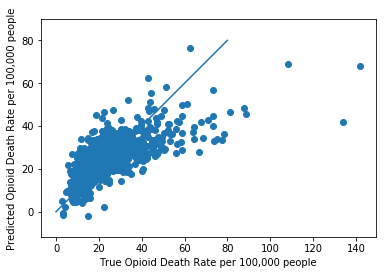

In [109]:
# fit lasso with a particular alpha
lreg = linear_model.Lasso(alpha = 0.5, max_iter=10000)
lreg.fit(trainX, trainY)

pred = lreg.predict(devX)

mse = np.mean((pred - devY)**2)
print(mse)

score = lreg.score(devX,devY)
print(score)
h = plt.figure()
plt.scatter(devY.values, pred)
plt.axis('equal')
plt.plot([0, 80], [0, 80])
plt.xlabel('True Opioid Death Rate per 100,000 people')
plt.ylabel('Predicted Opioid Death Rate per 100,000 people')

# sort the coefficients from smallest to largest
s = lreg.coef_
inds = sorted(range(len(s)), key=lambda k: s[k])

feature_names = features.columns.values
print('Positively correlated')
print(feature_names[inds[-10:]])    # last item in the list has the largest coeff
print(feature_names[inds[-1:]])

print('Negatively correlated')
print(feature_names[inds[:10]])

plt.savefig('Lasso_all_data')

In [110]:
# split the data into 2015 and 2016 rather than randomly

year_variable = data['year_keep']
year2016_index = (year_variable == 2016.0).values
print(year2016_index)

print(data.shape)
data_2016 = data[year2016_index]
print(data_2016.shape)


response_2016 = data_2016['Crude Rate']
features_2016 = data_2016.drop('Crude Rate', axis=1, inplace = False)
features_2016 = features_2016.drop('year_keep', axis=1, inplace = False)


features_2016_scale = preprocessing.scale(features_2016)


[False  True False ..., False  True  True]
(1846, 600)
(960, 600)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [111]:
# Lasso on 2015 to predict 2016 

year2015_index = (year_variable == 2015.0).values
data_2015 = data[year2015_index]
print(data_2015.shape)


response_2015 = data_2015['Crude Rate']
features_2015 = data_2015.drop('Crude Rate', axis=1, inplace = False)
features_2015 = features_2015.drop('year_keep', axis=1, inplace = False)

(886, 600)


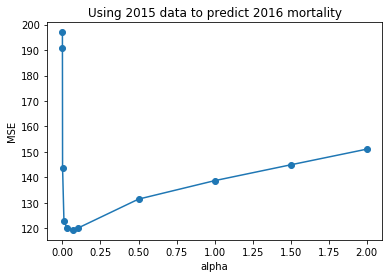

In [103]:

# test a range of alpha parameters

alpha = [0.00001, 0.0001,0.001,0.01,0.03, 0.07,0.1,0.5,1, 1.5, 2]
mse = np.zeros((len(alpha),1))
for i in np.arange(len(alpha)):
    lreg = linear_model.Lasso(alpha = alpha[i], max_iter=10000)
    lreg.fit(preprocessing.scale(features_2015), response_2015)

    pred = lreg.predict(features_2016_scale)

    mse[i] = np.mean((pred - response_2016)**2)
    
    

print(mse)

# best alpha is 0.07

plt.figure()
plt.plot(alpha, mse, 'o-')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Using 2015 data to predict 2016 mortality')
plt.savefig('choosing_alpha_2015_2016')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


120.04439878227541
0.422465577296
Positively correlated
['percent!!units in structure!!total housing units!!10 to 19 units'
 'percent!!selected monthly owner costs (smoc)!!housing units with a mortgage!!$1,500 to $1,999'
 'percent!!gross rent!!occupied units paying rent!!less than $500'
 'long commute - driving alone value'
 'percent!!house heating fuel!!occupied housing units!!bottled, tank, or lp gas'
 'percent!!disability status of the civilian noninstitutionalized population!!65 years and over!!with a disability.1'
 'percent!!mortgage status!!owner-occupied units!!housing units with a mortgage'
 'percent!!hispanic or latino and race!!total population!!not hispanic or latino!!white alone'
 'premature death value' 'injury deaths value']
['injury deaths value']
Negatively correlated
['percent!!year of entry!!native!!entered 2010 or later.1'
 'motor vehicle crash deaths value'
 'percent!!educational attainment!!population 25 years and over!!some college, no degree.1'
 'population livin

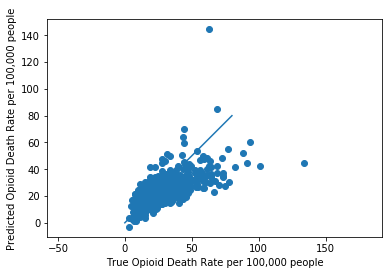

In [112]:
# fit lasso on a particular alpha 
lreg = linear_model.Lasso(alpha = 0.1, max_iter = 10000)
lreg.fit(preprocessing.scale(features_2015), response_2015)

         
pred = lreg.predict(features_2016_scale)

mse = np.mean((pred - response_2016)**2)
print(mse)

score = lreg.score(features_2016_scale,response_2016)
print(score)
h = plt.figure()
plt.scatter(response_2016, pred)
plt.axis('equal')
plt.plot([0, 80], [0, 80])
plt.xlabel('True Opioid Death Rate per 100,000 people')
plt.ylabel('Predicted Opioid Death Rate per 100,000 people')
#print(lreg.coef_)

index_array = lreg.coef_ > 0.001

feature_names = features.columns.values



# sort the coefficients from smallest to largest
s = lreg.coef_
inds = sorted(range(len(s)), key=lambda k: s[k])

feature_names = features.columns.values
print('Positively correlated')
print(feature_names[inds[-10:]])    # last item in the list has the largest coeff
print(feature_names[inds[-1:]])

print('Negatively correlated')
print(feature_names[inds[:10]])
